<a href="https://colab.research.google.com/github/jinsu1214/class2022spring/blob/main/speech_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pitch는 음의 높낮이를 말하고 intensity는 음의 진폭과 관련이 있다. 같은 음이더라도 세게 말하면 intensity가 강하게 나온다.  
중요!! spectogram에서 y축이 frequency이다. 따라서 spectogram의 진하기를 통해 몇 정도의 주파수가 높은지 알 수 있다.  
spectogram에서 일부분을 가져와서 spectrum을 보면 x축이 spectrum이 된다.  
inner product: 어느 숫자와 똑같은 길이의 숫자가 있을 때 같은 위치에 있는 숫자끼리 곱한 다음에 다 더하면 하나의 값이 나오는데 이것이 inner product이다. 하지만 이 때 나오는 수가 복소수 형태라는 것을 기억하자. abs를 사용해주면 원점과 (a,b) 사이의 거리를 알 수 있다.  
praat이라는 사이트를 이용해서 살펴보았을 때 위에 있는 것을 확대해주면 일정한 패턴이 반복된다는 것을 발견할 수 있다. 이 때 패턴이 0.00729초 마다 반복될 때 우리는 이러한 패턴이 1초에 몇번 들어가는지 또한 알고 싶어진다. 따라서 1/0.007을 해주면 대략 137이 나오는데 137이 바로 이 구간에서의 주파수가 된다.  
하지만 원래는 이렇게 구하지 않는다. Auto correlation을 통해 구한다.  
Auto correlation : 값들이 있을 때 똑같은 값들을 만들어 옆으로 움직일 때 어느순간에 비슷해지는 순간이 나오게 된다. 이것을 x축이 lag y축이 correlation인 그래프로 나타내면 움직인 거리가 0이라서 자기 자신과 했을 때 1이라는 가장 큰 값을 가지게 되다가 점점 작아지다가 올라왔다가 내려갔다가 올라오기를 반복한다. lag을 할 때 1을 제외한 그 다음으로 큰 값이 나오는 때가 있는데 이 순간의 0과 lag 값 사이의 거리랑 반보된는 값들의 주기랑 같다.패턴이 반복되는 순간까지 걸리는 정도가 다음 피크가 생기는 lag값이랑 같은 것이다.  
첫번째 lag의 시간으로 1을 나눠주게 되면 이것이 pitch값이다.  
root mean square(RMS): signal이 있을 때 모든 값들을 제곱을 해준다. 그리고 다 더하고 1/n해서 평균값을 구한다. 그리고 제곱을 했기 떄문에 원래대로 돌려놓기 위하여 root를 씌워준다. 그러면 intensity 값이 나오게 된다.

성대에서만 만들어지는 소리를 source라고 하고 성대 위에서 만들어지는 소리를 vocal tract라고 한다. 
pulse train: 주어진 주파수가 100Hz면 이것을 2배, 3배, 4배.... 한 후에 다 더하면 이것이 source다.   
우리의 목 자체가 filter이다. 아에이오우를 분석할 때 이미 연구자들이 a가 어떤 주파수에서 강한지 조사해 두었다. 750에서 극대값을 가진다. 이 떄 x축이 frequency이기 때문에 spectrum인 것을 알 수 있다.  
표를 보면 마지막에 BW가 있는데 이는 band with이다. 극대 값들에 f1, f2, f3라고 이름 붙인다. 이때 bw는 극대값의 폭을 말하는데 만약 폭이 넓다면 완만한 것이고 폭이 작으면 매우 뾰족할 것이다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

In [2]:
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

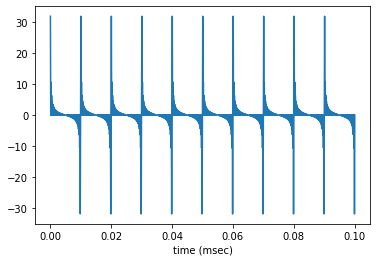

In [3]:
# parameter setting
amp = 1
sr = 10000
dur = 0.5

F0 = 100
Fend = int(sr/2)  

phase = 0

s_all = 0
for freq in range(F0, Fend+1, F0):
  s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
  s_all += s

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s_all[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s_all, rate=sr)

지난 시간에 배웠던 필터는 어떤 숫자를 넣어야 하는지 몰랐지만 오늘 배운 filter는 극대값들이 spectrum을 보면 알 수 있기에 더욱 직관적이다. 따라서 극대값들을 지난시간에 배운 filter에 사용할 수 있도록 바꾸는 과정을 함수로 지정해 놓았고 이는 이해할 필요 없이 그냥 봐라.  


In [4]:
def hz2w(F, sr):
    NyFreq = sr/2;
    w = F/NyFreq *np.pi;
    return w

def resonance (srate, F, BW):
    a2 = np.exp(-hz2w(BW,srate))
    omega = F*2*np.pi/srate
    a1 = -2*np.sqrt(a2)*np.cos(omega)
    a = np.array([1, a1, a2])
    b = np.array([sum(a)])
    return a, b

In [5]:
s = s_all

In [6]:
from scipy.signal import lfilter

RG = 0  # RG is the frequency of the Glottal Resonator
BWG = 100  # BWG is the bandwidth of the Glottal Resonator
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [7]:
RG = 750  # RG is the frequency of the 1st Formant
BWG = 90  # BWG is the bandwidth of the 1st Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [8]:
RG = 1187  # RG is the frequency of the 2nd Formant
BWG = 110  # BWG is the bandwidth of the 2nd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [9]:
RG = 2595  # RG is the frequency of the 3rd Formant
BWG = 170  # BWG is the bandwidth of the 3rd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [10]:
RG = 3781  # RG is the frequency of the 4th Formant
BWG = 250  # BWG is the bandwidth of the 4th Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

점점 사람 목소리랑 비슷해진다.

In [11]:
s = lfilter(np.array([1, -1]), np.array([1]), s)
ipd.Audio(s, rate=sr)

이거는 입술 효과를 준다고 한다. 이해는 못하겠다.  
모음: source -> filter(입)

LPC filter coefficients  
푸리에랑 비슷한데 차이점은 이것은 모음에만 사용 가능하다는 것이다.  
H * Y = X (X는 pulse train) 여기서 H는 어떻게 shift 시킬 것인지에 대한 내용이다.  
pulse train은 성대에서 나는 소리이다. 따라서 a를 말하든 e를 말하든 주파수만 닽다면 무엇을 말하던지 같은 소리가 나온다.  Y에 해당하는 부분이 이 소리가 a인지 e인지 i인지 구분해준다.  
x의 관점에서 보면 lfilter의 a 계수값을 구하는 것이다.

In [12]:
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')
ipd.Audio(s[7000:12000], rate=sr)

In [13]:
import scipy
M = int(sr/1000+4) # Number of LPC coefficnets
a = librosa.lpc(s[7000:12000], M)

여기서 M은 H?에 해당한다고 이해했음. 1/2처럼 coefficient값인 것 같음

(0.0, 5000.0)

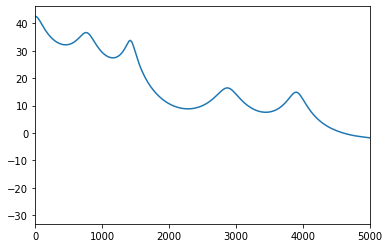

In [14]:
w, h = scipy.signal.freqz(1, a)
plt.plot (w*sr/(2*np.pi), 20*np.log10(np.abs(h)))
plt.xlim((0,5000))


이 그래프에서 x축은 frequency이고 y축은 데시벨이다.  
a모음의 filter가 이렇게 생겼음을 보여준다. 원래는 평평하게 생겼었다.

피크에 해당하는 부분을 formants라고 한다. 아래 내용은 학부 수준에서 어렵고 대학원 진학해서 배워라 근데 안갈거에요^^

In [15]:
BWcutoff = 2000;
F = np.sort(np.angle(np.roots(a)))
order = np.argsort(np.angle(np.roots(a)))
F = F*sr/(2*np.pi);

BW = -2*np.log(abs(np.roots(a)))*sr/(2*np.pi);
BW = BW[order];

idx = [i for i in range(F.shape[0]) if (F[i] > 0) & (BW[i] < BWcutoff) ]

print(F[idx])
print(BW[idx])

[  773.0751  1427.4038  2873.7573  3904.3184  4630.678   5151.7295
  7404.265   7795.8794  8694.367   9274.946  10049.233 ]
[ 229.41571  130.27097  307.47186  229.12651 1215.9471   542.4114
  202.3538   303.34442 1630.4275   210.64189 1169.2583 ]
